<a href="https://colab.research.google.com/github/ishaan10dutta/Time-Series-Forecasting-Analysis-Ensemble-in-Python/blob/master/Time_Series_Forecasting_Analysis_ARIMA%2C_Feature_Extraction%2C_LSTM_stock_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Time series Forecasting and Analysis using Python.**

A time series is a sequential set of data points, measured typically over successive times.

It is mathematically defined as a set of vectors x(t), t = 0,1,2,... where t represents the time elapsed, where the variable x(t) is treated as a random variable.

The measurements taken during an event in a time series are arranged in a proper chronological order.


##**Time Series Forecasting Analysis** 
This project involves developing models used to describe the observed time series and understand the trends and reasons behind the dataset. 

This involves creating assumptions and interpretation about a given data. 

Time Series Forecasting makes use of the best fitting model essential to predicting the future observation based on complex processing of the current and previous data.

### Understanding the components of the time series data:

* **Trends** (to describe increasing or decreasing behavior of the time series frequently presented in linear modes).
* **Seasonality** (to highlight the repeating pattern or cycles of behavior over time) 
* **Irregularity/Noise**(to regard the non-systematic aspect of time series deviating from the common model values)
* **Cyclicity**(to identify the repetitive changes in the time series and define their placement in the cycle). 


###Business Use Cases of Time Series Forecasting include:
**Sales forecast** - retail products sales forecast

**Demand forecasting** - used in pricing, inventory and workforce management

**Traffic forecasting** - transport and route optimization, road facility design

**Revenue forecasting** - budgeting, target setting

The dataset used in this project is the AMZN stock price data, from 2010-2020, parsed from Yahoo Finance.

I will make use of different models and methods for the time series forecasting, and analyze how they compare against each other.

### Setting up 

In [258]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [259]:
link = 'https://drive.google.com/open?id=1Qq9A3hV-x7D4R9lDG178_z0VeEj7c9Gi'
fluff, id = link.split('=')

import pandas as pd
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('AMZN.csv')

In [ ]:
pip install mxnet

In [261]:
import time
import numpy as np

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [262]:
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(2020)

In [263]:
def parser(x):
    return datetime.datetime.strptime(x,'%m/%d/%Y')

### Loading the dataset

In [264]:
import pandas as pd

data_df = pd.read_csv("AMZN.csv", header=0, parse_dates=[0], date_parser=parser)

In [265]:
data_df[['Date', 'Close']].head(3)

,Date,Close
0,2010-01-04,133.899994
1,2010-01-05,134.690002
2,2010-01-06,132.250000


In [266]:
data_df.describe()

,Open,High,Low,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,Fourier,ARIMA,Close,labels
count,2265.000000,2265.000000,2265.000000,2265.000000,2.265000e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2265.000000,0.0
mean,553.000949,558.568702,546.430821,552.743179,4.603646e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,552.743179,NaN
std,470.155920,474.660681,463.993737,469.357785,2.954860e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,469.357785,NaN
min,105.930000,111.290001,105.800003,108.610001,9.844000e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108.610001,NaN
25%,217.649994,219.979996,214.460007,217.830002,2.786500e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,217.830002,NaN
50%,334.679993,336.760010,328.940002,332.910004,3.872500e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,332.910004,NaN
75%,766.599976,771.219971,761.200012,767.330017,5.425000e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,767.330017,NaN
max,2038.109985,2050.500000,2013.000000,2039.510010,4.242110e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2039.510010,NaN


In [267]:
data_df.shape

(2265, 20)

In [268]:
print('There are {} number of days in the dataset.'.format(data_df.shape[0]))

There are 2265 number of days in the dataset.


## Data Preprocessing and Visualizations

Most stock price time series analysis are concerned with closing prices. The reason is because closing prices generally summarize the way business was going better than opening prices or average prices.

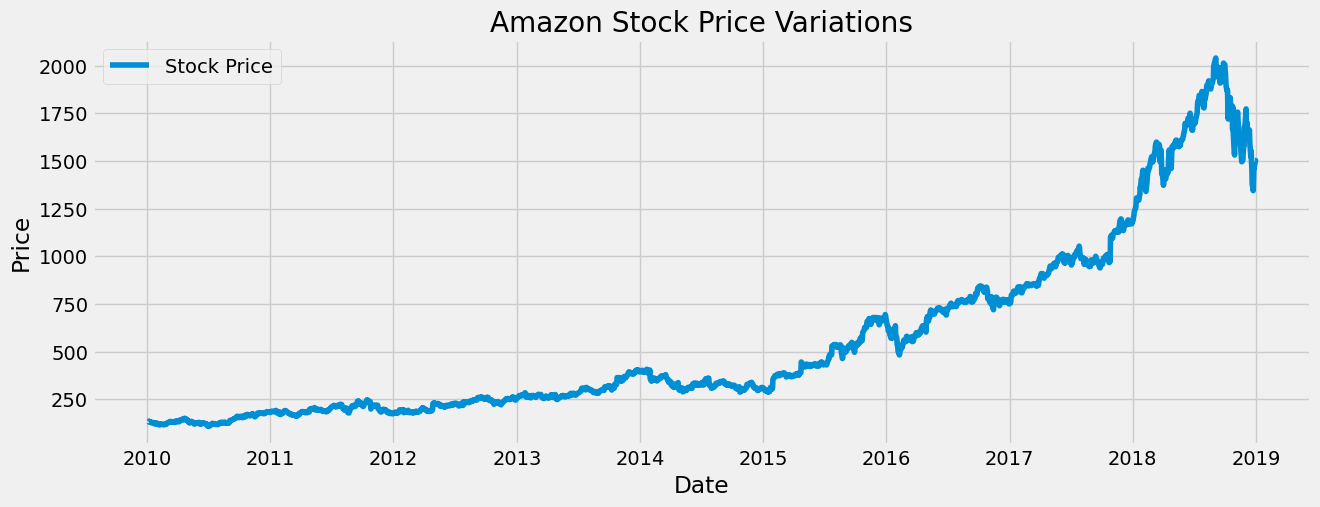

In [371]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(data_df['Date'], data_df['Close'], label='Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Amazon Stock Price Variations')
plt.legend(loc='best')
plt.show()

From the closing prices plot, we clearly see Amazon's business really boomed after 2010 and then peaked after 2015. This puts a lot of stationarity in the data from 2010-2015, and then an exponential growth. 
Thus, testing will be very interesting since most of the data is in the exponential growth period. 

I plan on normalizing the training data such that similar data points over the same time are reduced to one single data point so that the model can train in such a way it can expect the exponential growth after 2015.

Feature Engineering is also necessary to identify and generate more indicators for better predictions.

##### Kernel Density Estimate(KDE) Plot 
It is used for visualizing the Probability Density of a continuous variable. It depicts the probability density at different values in a continuous variable.

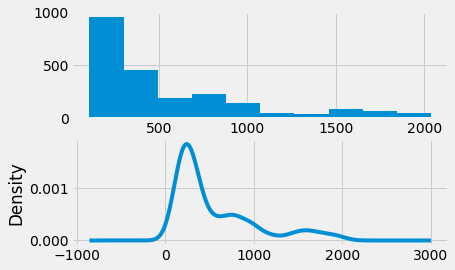

In [270]:
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
data_df.Close.hist()
pyplot.subplot(212)
data_df.Close.plot(kind='kde')
pyplot.show()

From the plot, we can see-
*   The distribution is not perfectly Gaussian (normal distribution).
*   The distribution is left shifted.
    
*   A Time Series is said to be stationary if its statistical properties such as mean, variance remain constant over time.
*   Intuitively, we can say that if a Time Series has a particular behaviour over time, there is a very high probability that it will follow the same in the future.



# Feature Generation

The technical indicators I tried to generate were-

* The moving average (MA) is a simple technical analysis tool that smooths out price trends by creating a constantly updated average price, and  filtering out the “noise” from random short-term price fluctuations.

* EMA: Exponential moving average are an advanced version of a simple moving averages, without SMAs lag. Moving averages just average out the data for a given time so we know how the company's closing price are trending for a given amount of days. 

  I used the ewm(exponential weighted mean ) function to calculate ema.

* Momentum: Momentum is the simplest and easiest oscillator (financial analysis tool) to understand and use. It is the measurement of the speed or velocity of price changes, or the rate of change in price movement for a particular asset.

  The formula for momentum is:
  Momentum = V−Vx where:
  V=Latest price
  Vx=Closing price
  x=Number of days ago

* Moving Average Convergence Divergence (MACD) is a trend-following momentum indicator that shows the relationship between two moving averages of a security’s price. 
  
  The MACD is calculated by subtracting the 26-period Exponential Moving Average (EMA) from the 12-period EMA. 
  
  MACD helps investors understand whether the bullish or bearish movement in the price is strengthening or weakening.

* Bollinger Bands are used to define the prevailing high and low prices in a market to characterize the trading band of a financial commodity. 
  
  Bollinger Bands are a volatility indicator. Bands consists of a Moving Average (MA) line, a upper band and lower band. 
  
  The upper and lower bands are simply MA adding and subtracting standard deviation.


In [271]:
def get_technical_indicators(dataset): #function to generate feature technical indicators
    
    #Create Moving Average for 7 and 21 days
    dataset['ma7'] = dataset['Close'].rolling(window = 7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window = 21).mean()
    
    #Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])
    
    #Create Bollinger Bands
    dataset['20sd'] = dataset['Close'].rolling(window = 20).std()
    dataset['upper_band'] = (dataset['Close'].rolling(window = 20).mean()) + (dataset['20sd']*2)
    dataset['lower_band'] = (dataset['Close'].rolling(window = 20).mean()) - (dataset['20sd']*2)
    
    #Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()

    #Create Momentum
    dataset['momentum'] = (dataset['Close']/100)-1
    
    return dataset

In [273]:
data_df = pd.read_csv("AMZN.csv", header=0, parse_dates=[0], date_parser=parser)

In [274]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2265 entries, 0 to 2264
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        2265 non-null   datetime64[ns]
 1   Open        2265 non-null   float64       
 2   High        2265 non-null   float64       
 3   Low         2265 non-null   float64       
 4   Adj Close   2265 non-null   float64       
 5   Volume      2265 non-null   int64         
 6   ma7         0 non-null      float64       
 7   ma21        0 non-null      float64       
 8   26ema       0 non-null      float64       
 9   12ema       0 non-null      float64       
 10  MACD        0 non-null      float64       
 11  20sd        0 non-null      float64       
 12  upper_band  0 non-null      float64       
 13  lower_band  0 non-null      float64       
 14  ema         0 non-null      float64       
 15  momentum    0 non-null      float64       
 16  Fourier     0 non-null  

In [275]:
data_tech_df = get_technical_indicators(data_df)

In [276]:
data_tech_df.head()

,Date,Open,High,Low,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,Fourier,ARIMA,Close,labels
0,2010-01-04,136.250000,136.610001,133.139999,133.899994,7599900,NaN,NaN,133.899994,133.899994,0.000000,NaN,NaN,NaN,133.899994,0.3390,NaN,NaN,133.899994,NaN
1,2010-01-05,133.429993,135.479996,131.809998,134.690002,8851900,NaN,NaN,134.310190,134.327915,0.017725,NaN,NaN,NaN,134.492500,0.3469,NaN,NaN,134.690002,NaN
2,2010-01-06,134.600006,134.729996,131.649994,132.250000,7178800,NaN,NaN,133.569984,133.516904,-0.053080,NaN,NaN,NaN,132.940000,0.3225,NaN,NaN,132.250000,NaN
3,2010-01-07,132.009995,132.320007,128.800003,130.000000,11030200,NaN,NaN,132.571973,132.406755,-0.165217,NaN,NaN,NaN,130.955500,0.3000,NaN,NaN,130.000000,NaN
4,2010-01-08,130.559998,133.679993,129.029999,133.520004,9830500,NaN,NaN,132.791825,132.709221,-0.082604,NaN,NaN,NaN,132.672234,0.3352,NaN,NaN,133.520004,NaN


Plotting the technical indicators

In [279]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10))
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Amazon in the last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

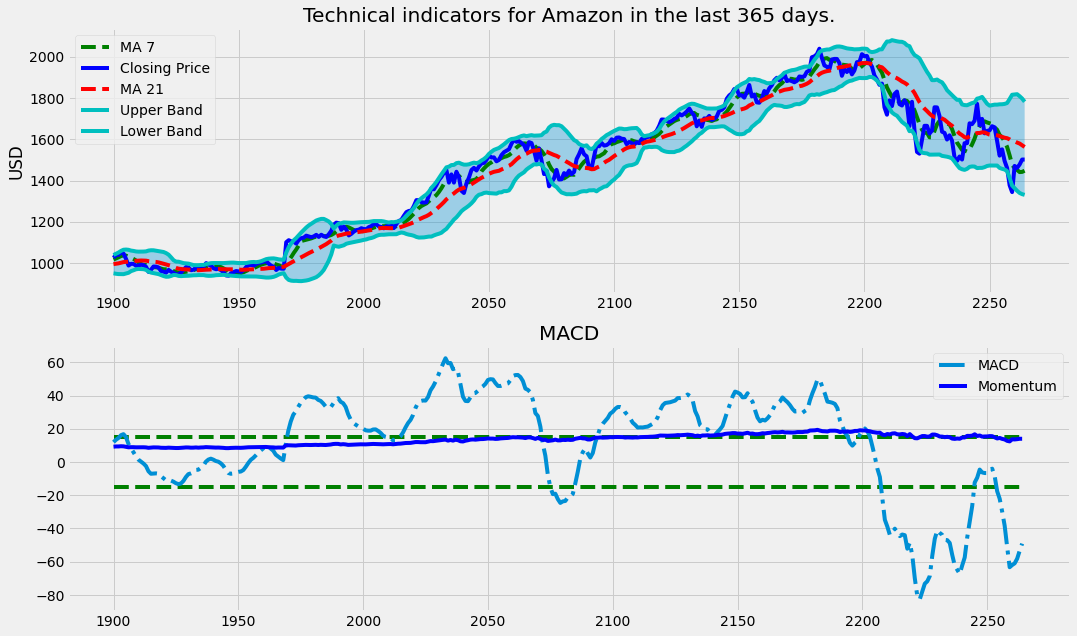

In [280]:
plot_technical_indicators(data_tech_df, 365)

### PLOT UNDERSTANDING:

* The first plot shows the trends in moving average windows of 7 and 21 days, in comparison to the actual closing price. 

  We also have the upper and lower Bollinger Bands, obtained by adding the MA+Std and MA-Std.

* The second plot shows the threshold between MACD and Momentum.The MACD obviously depends on the MA values, and the Momentum shows an average value of the MACD in between the peak highest and lowest values.

# Analysis of Time Series using Fourier Transform

Fourier transform (FT) decomposes a time-domain function into the frequency domain. An audio wave in the time domain is decomposed into its constituent frequencies and volume (amplitude). 

Mathematically, FT involves taking the integral of a complex number notation, ie i.

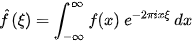



In [281]:
data_FT = data_df[['Date', 'Close']]
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

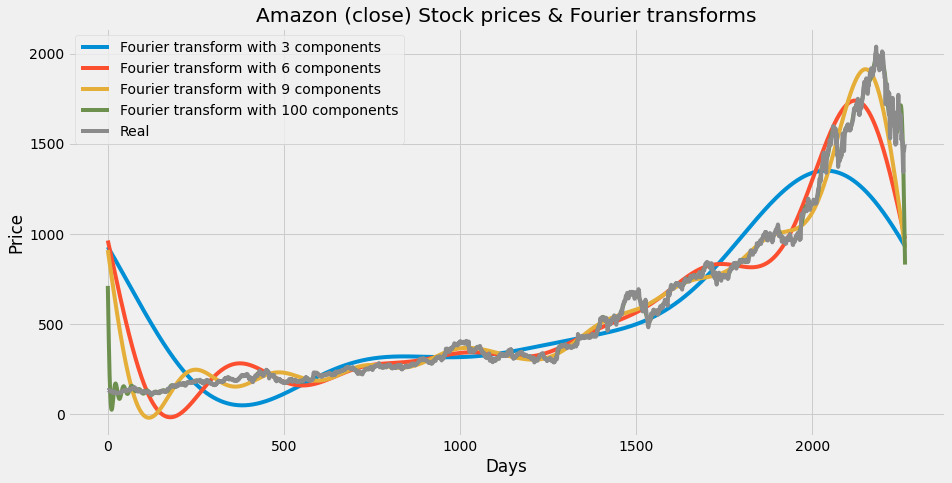

In [282]:
plt.figure(figsize=(14, 7))
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['Close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Amazon (close) Stock prices & Fourier transforms')
plt.legend()
plt.show()

Fourier Transform uses many spectral components to try and train data. From time domain it is converted to frequency domain and then calculated. After that, the components are converted back into time domain where and plotted. 

Fourier Transform as an indicator helps to extract the predominate cycle from a series of data

Reference: https://www.metastock.com/customer/resources/taaz/?p=58

In the above example we can see the spectral component of 100 is closest to the real price so we will move ahead with 100


In [283]:
def get_fourier(dataset):
    data_FT = dataset[['Date', 'Close']]
    close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
    close_fft = np.fft.ifft(close_fft)
    close_fft
    fft_df = pd.DataFrame({'fft':close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
    fft_list = np.asarray(fft_df['fft'].tolist())
    fft_list_m10= np.copy(fft_list); fft_list_m10[100:-100]=0
    dataset['Fourier'] = pd.DataFrame(fft_list_m10).apply(lambda x: np.abs(x))
    return dataset

In [284]:
data_tech_df = get_fourier(data_df)

In [285]:
data_tech_df.head(5)

,Date,Open,High,Low,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,Fourier,ARIMA,Close,labels
0,2010-01-04,136.250000,136.610001,133.139999,133.899994,7599900,NaN,NaN,133.899994,133.899994,0.000000,NaN,NaN,NaN,133.899994,0.3390,133.899994,NaN,133.899994,NaN
1,2010-01-05,133.429993,135.479996,131.809998,134.690002,8851900,NaN,NaN,134.310190,134.327915,0.017725,NaN,NaN,NaN,134.492500,0.3469,134.690002,NaN,134.690002,NaN
2,2010-01-06,134.600006,134.729996,131.649994,132.250000,7178800,NaN,NaN,133.569984,133.516904,-0.053080,NaN,NaN,NaN,132.940000,0.3225,132.250000,NaN,132.250000,NaN
3,2010-01-07,132.009995,132.320007,128.800003,130.000000,11030200,NaN,NaN,132.571973,132.406755,-0.165217,NaN,NaN,NaN,130.955500,0.3000,130.000000,NaN,130.000000,NaN
4,2010-01-08,130.559998,133.679993,129.029999,133.520004,9830500,NaN,NaN,132.791825,132.709221,-0.082604,NaN,NaN,NaN,132.672234,0.3352,133.520004,NaN,133.520004,NaN


#ARIMA MODEL

ARIMA stands for Auto Regressive Integrated Moving Average.

It is one of the most popular traditional models for predicting future values of time series data.

I will not be using ARIMA as my final prediction model, but it will be useful to denoise the data a little and possibly extract some new patterns or features.

As the name suggests, ARIMA encapsulates-
1. AR: Autoregression: A model that uses the dependent relationship between an observation and some number of lagged observations.

2. I: Integrated: The use of differencing of raw observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

3. MA: Moving Average: A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

### The parameters of the ARIMA model are defined as follows:

ARIMA(p, d, q), where

p: The number of lag observations included in the model, also called the lag order. 

d: The number of times that the raw observations are differenced, also called the degree of differencing. 

q: The size of the moving average window, also called the order of moving average.

In [286]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

data_arima = data_df[['Date', 'Close']]
series = data_arima['Close']

model = ARIMA(series, order=(5, 1, 0)) #lag value=5, difference order of 1(to make time series stationary), MA=0
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2264
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -9244.973
Method:                       css-mle   S.D. of innovations             14.361
Date:                Fri, 11 Sep 2020   AIC                          18503.947
Time:                        16:10:41   BIC                          18544.021
Sample:                             1   HQIC                         18518.569
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.6074      0.291      2.086      0.037       0.037       1.178
ar.L1.D.Close    -0.0270      0.021     -1.287      0.198      -0.068       0.014
ar.L2.D.Close    -0.0002      0.021     

From the summary of the ARIMA model, we can see that most P-values are greater than 0.05, which indicates a decent model.

The difference between AIC and BIC is low, which is also a good sign.

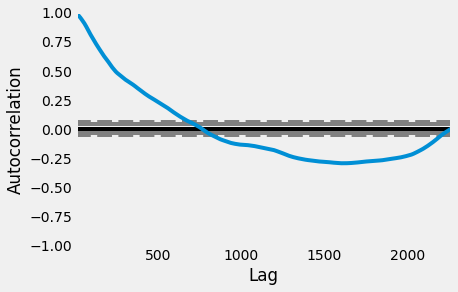

<Figure size 720x504 with 0 Axes>

In [287]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7))
plt.show()

Running our data, we can see that there is a positive correlation with close to the first 1000 lags.

In [288]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

data_tech_df['ARIMA'] = pd.DataFrame(predictions)

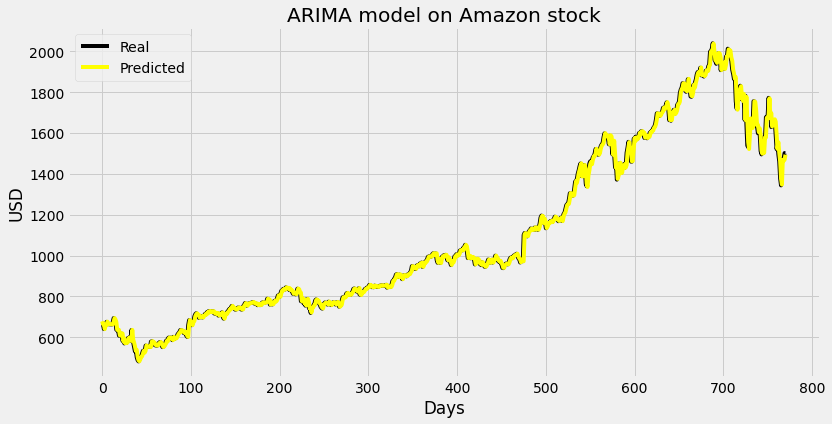

In [290]:
plt.figure(figsize=(12, 6))
plt.plot(test, color='black', label='Real')
plt.plot(predictions, color='yellow', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('ARIMA model on Amazon stock')
plt.legend()
plt.show()

In [300]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 557.865


ARIMA gives a very good approximation of the real stock price. I will use the predicted price through ARIMA as an input feature into the LSTM in order to capture as many features and patterns about the data as possible.


## Feature Extraction using XGBoost

* With so many features we have to consider whether all of them are really indicative of the direction the stock will take.XGBoost gives some of the best results in both classification and regression problems.


* XGBoost is a decision-tree-based ensemble Machine Learning algorithm that applies the principle of boosting weak learners in the framework. In medium sized structured/tabular data, decision tree based algorithms give some of the best results. 

So, after adding all types of data (the correlated assets, technical indicators, fundamental analysis and Arima) we get a total of 19 features for the 2,626 days (before training-testing split).

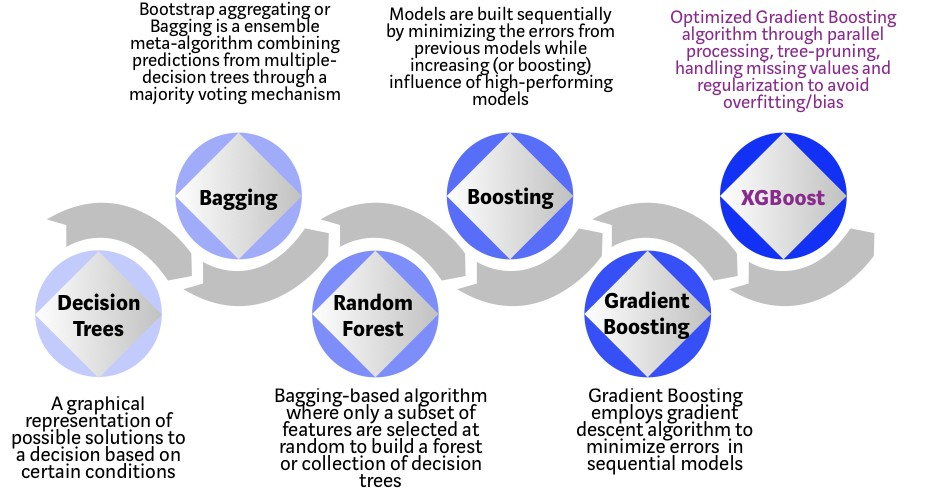


In [291]:
data_df.head(5)

,Date,Open,High,Low,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,Fourier,ARIMA,Close,labels
0,2010-01-04,136.250000,136.610001,133.139999,133.899994,7599900,NaN,NaN,133.899994,133.899994,0.000000,NaN,NaN,NaN,133.899994,0.3390,133.899994,678.303785,133.899994,NaN
1,2010-01-05,133.429993,135.479996,131.809998,134.690002,8851900,NaN,NaN,134.310190,134.327915,0.017725,NaN,NaN,NaN,134.492500,0.3469,134.690002,664.043069,134.690002,NaN
2,2010-01-06,134.600006,134.729996,131.649994,132.250000,7178800,NaN,NaN,133.569984,133.516904,-0.053080,NaN,NaN,NaN,132.940000,0.3225,132.250000,663.388476,132.250000,NaN
3,2010-01-07,132.009995,132.320007,128.800003,130.000000,11030200,NaN,NaN,132.571973,132.406755,-0.165217,NaN,NaN,NaN,130.955500,0.3000,130.000000,640.204421,130.000000,NaN
4,2010-01-08,130.559998,133.679993,129.029999,133.520004,9830500,NaN,NaN,132.791825,132.709221,-0.082604,NaN,NaN,NaN,132.672234,0.3352,133.520004,660.576572,133.520004,NaN


In [292]:
print('The complete dataset now has {} samples and {} features.'.format(data_df.shape[0],data_df.shape[1]))

The complete dataset now has 2265 samples and 20 features.


In [293]:
def get_feature_importance(data_input):
    data = data_input.copy()
    y = data['Close']
    X = data.iloc[:,1:19]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [294]:
#Segregating into training and test data for feature importance
(X_train_feat, y_train_feat), (X_test_feat, y_test_feat) = get_feature_importance(data_tech_df)

In [295]:
regressor = xgb.XGBRegressor(gamma=0.0, n_estimators=200, base_score=0.7, colsample_bytree=1, learning_rate=0.05)

In [296]:
xgbModel = regressor.fit(X_train_feat,y_train_feat,
                         eval_set = [(X_train_feat, y_train_feat), (X_test_feat, y_test_feat)], 
                         verbose=False)

[16:15:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [297]:
eval_result = regressor.evals_result()

In [298]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

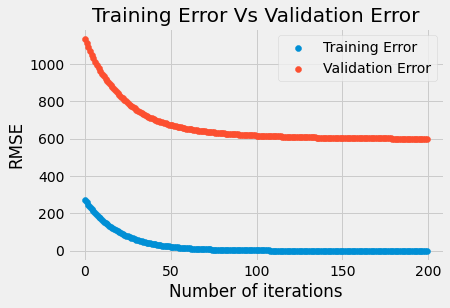

In [299]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Number of iterations')
plt.ylabel('RMSE')
plt.title('Training Error Vs Validation Error')
plt.legend()
plt.show()

The vast difference between the training and validation errors clearly show we have an underfit model.

This is expected, because of the way we have split the data into the training and testing sets, almost exactly when Amazon had its boom, and stock price increased exponentially.

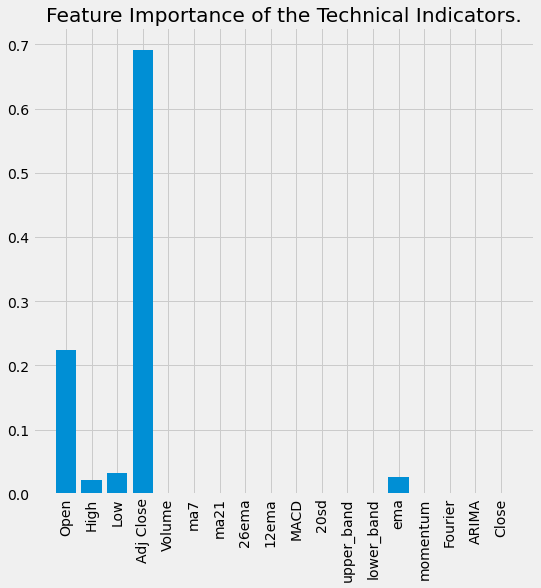

In [301]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_feat.columns)
plt.title('Feature Importance of the Technical Indicators.')
plt.show()

In stock trading, MA7, MA21 and EMA are some of the most important indicators. 

Here, features like Open and Adj Close are bound to be close to Closing prices. So if EMA doesn't works out I will focus on Averaging prices from Open and Adj-CLose prices.

Fourier and ARIMA could be important too, but because of the spectral component, and no new feature generation respectively, I will not be considering them.

# LSTM

Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They work tremendously well on a large variety of problems, and are now widely used.

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn.

All recurrent neural networks have the form of a chain of repeating modules of neural network. 

In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer.

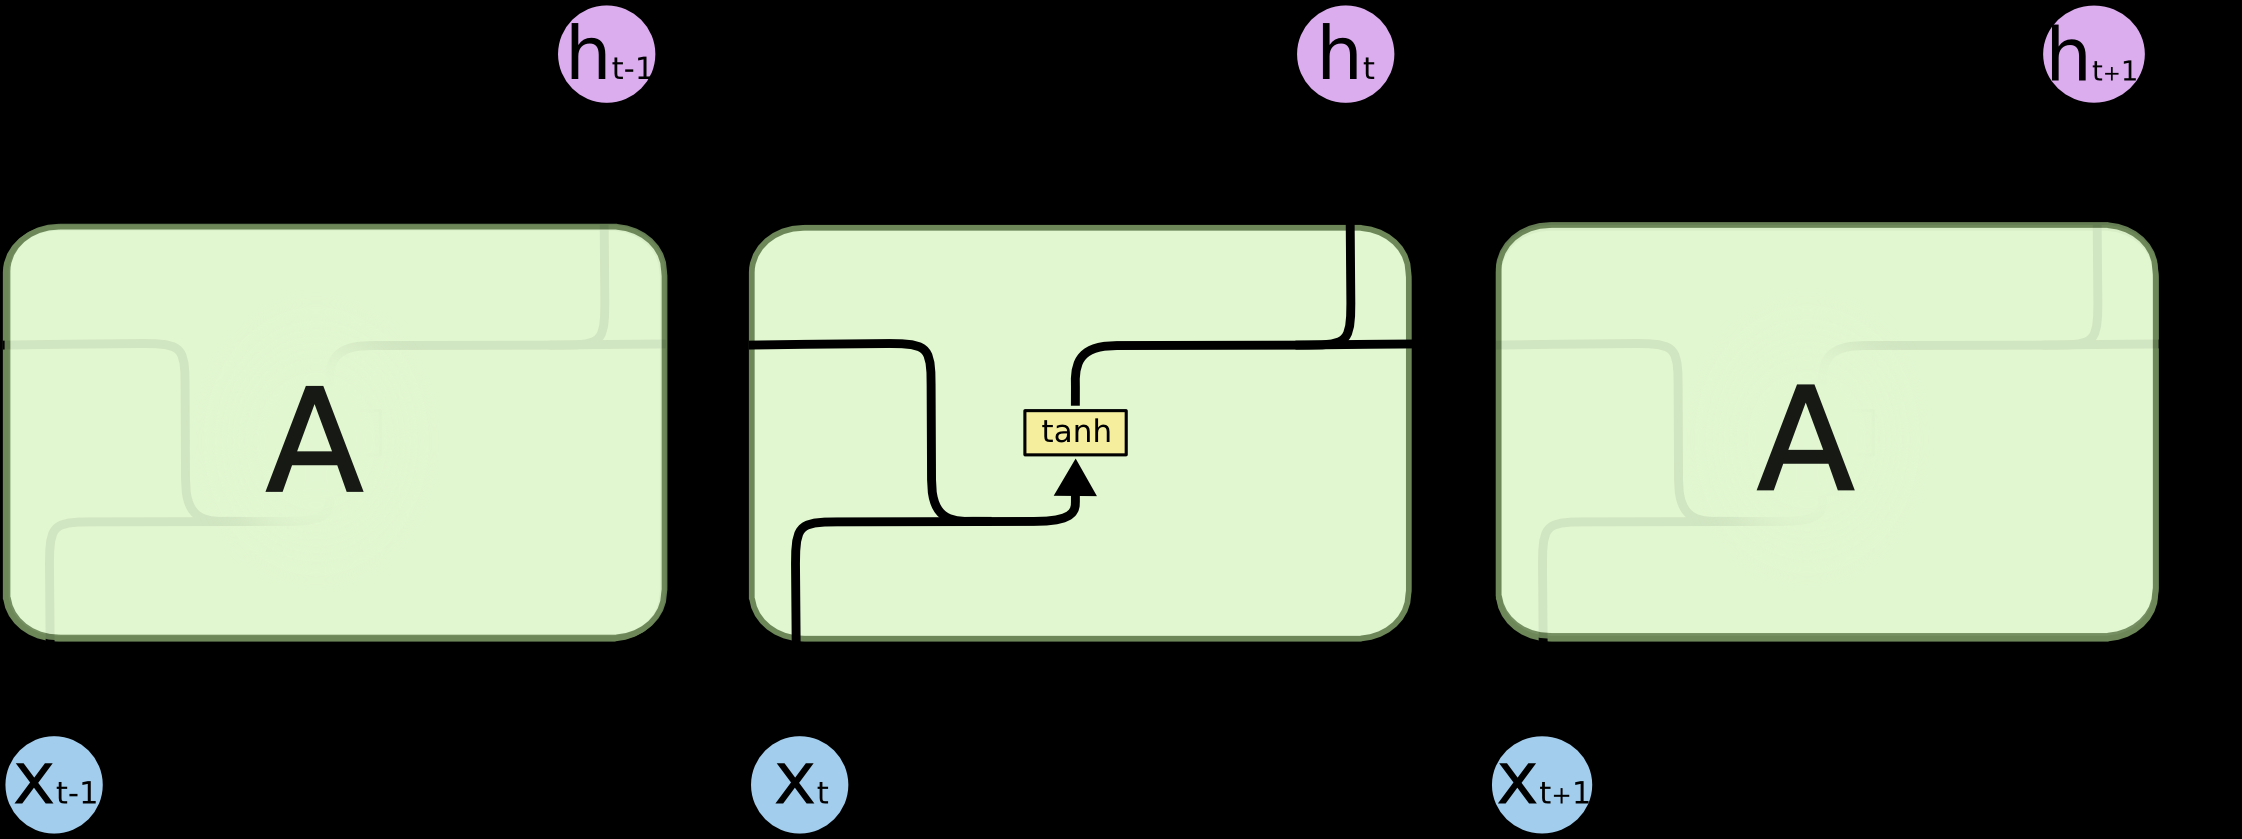

LSTMs also have this chain like structure, but the repeating module has a different structure. Instead of having a single neural network layer, there are four, interacting in a very special way.

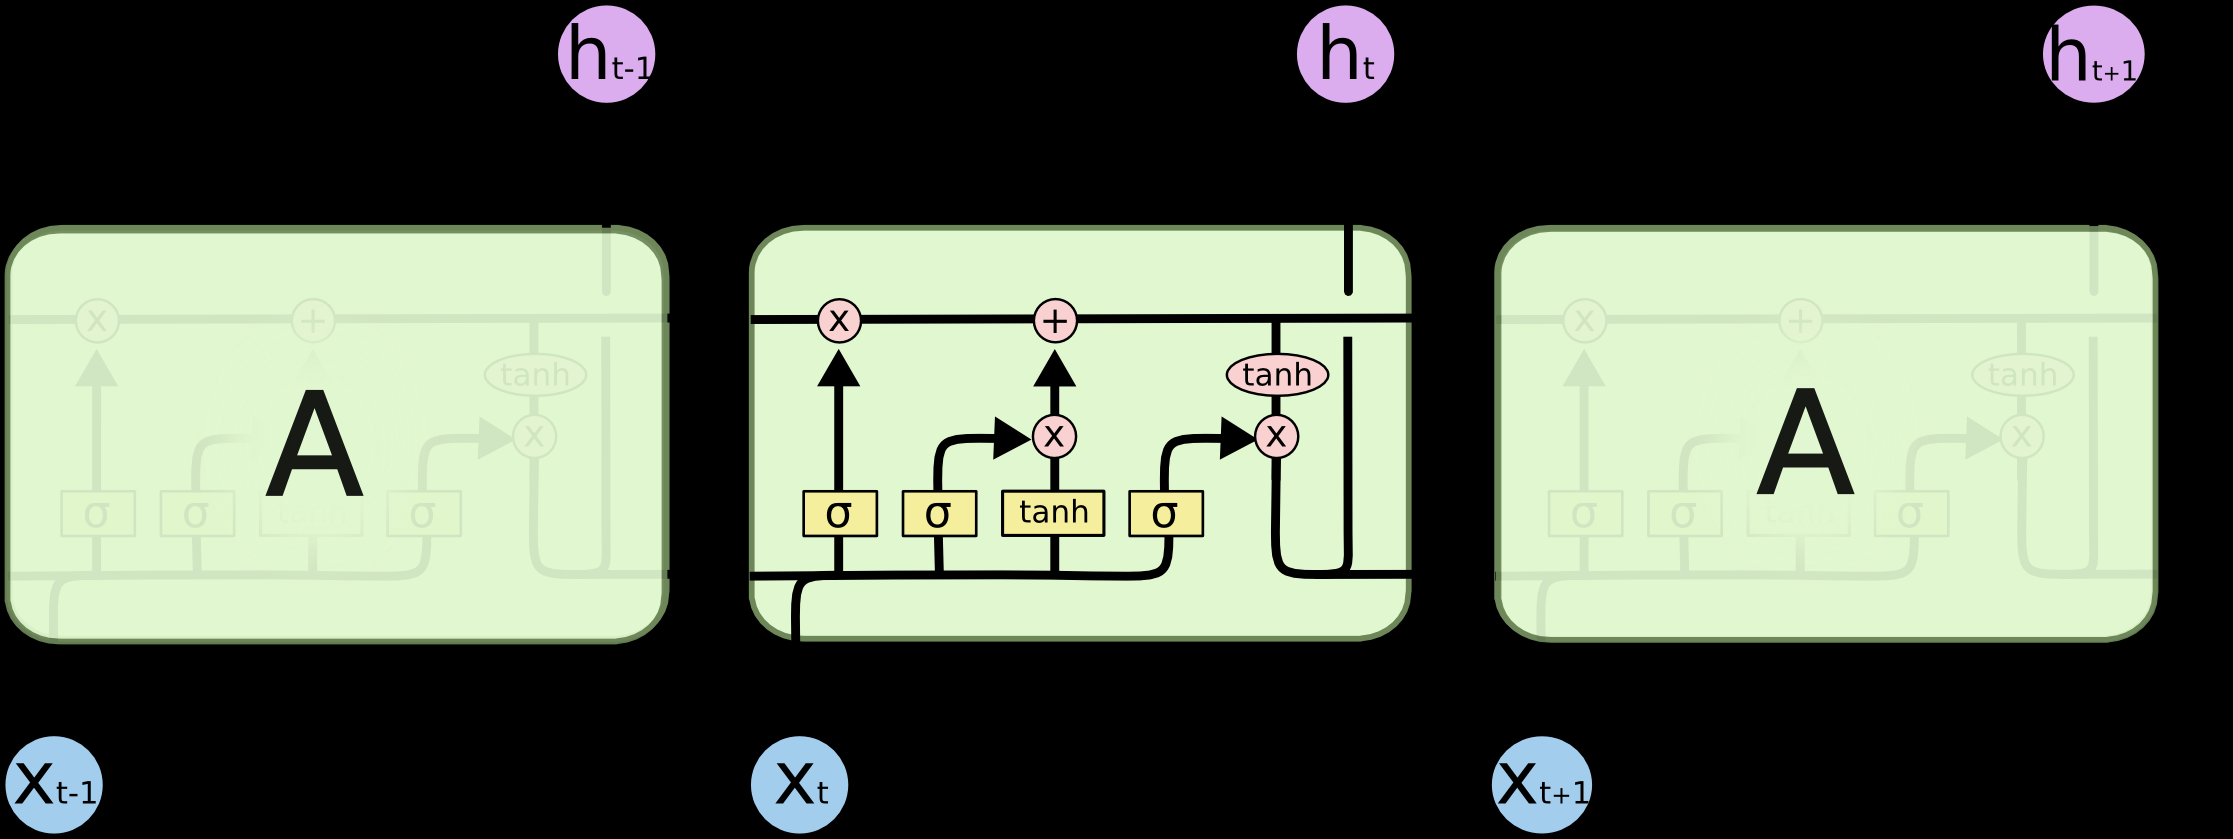



LSTMs are great at predicting stock market data. I will be trying to predict the closing prices using 1 feature Open(It has highest correlation to closing price) initially and then using multiple features(which have to be encoded, in a manner of one hot encoding) and then try to get a output.




## The understanding behind LSTMs

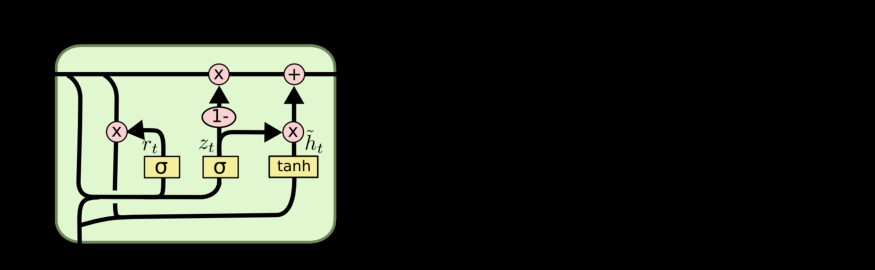

The new neuron has 3 gates, each with a different goal. The gates are:

1.Input Gate
2.Output Gate
3.Forget Gate

These control and add or remove information to the cell state, regulated by the sigmoid layer in the network. The sigmoid layer outputs numbers between zero and one, describing how much of each component should be let through to the next cell state.

An LSTM Neuron still receives as input its previous state-

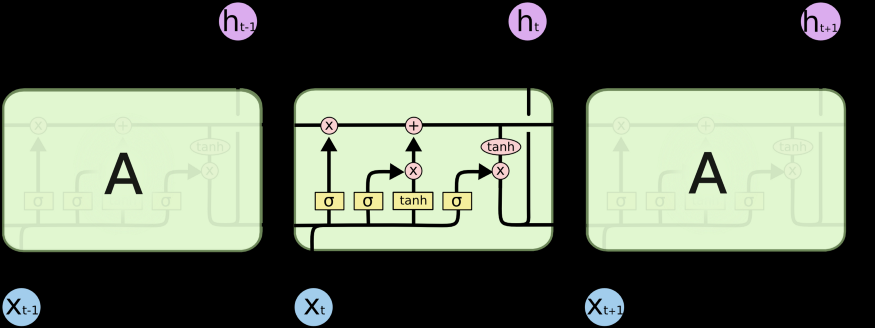



To prepare the data for the LSTM, we need to:

1. Clean up the data and remove any NANs
2. Create a test, train and validation set
3. Create train for Open Price
4. Normalize data
5. Create a feature and label set
6. Train, test data and check with validation set
7. Make a prediction
8. Based on this prediction find if the feature extraction method of LSTM works

##Data Preprocessing

In [302]:
data_lstm = data_tech_df.drop(columns='Date')
data_lstm.head(5)

,Open,High,Low,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,Fourier,ARIMA,Close,labels
0,136.250000,136.610001,133.139999,133.899994,7599900,NaN,NaN,133.899994,133.899994,0.000000,NaN,NaN,NaN,133.899994,0.3390,133.899994,678.303785,133.899994,NaN
1,133.429993,135.479996,131.809998,134.690002,8851900,NaN,NaN,134.310190,134.327915,0.017725,NaN,NaN,NaN,134.492500,0.3469,134.690002,664.043069,134.690002,NaN
2,134.600006,134.729996,131.649994,132.250000,7178800,NaN,NaN,133.569984,133.516904,-0.053080,NaN,NaN,NaN,132.940000,0.3225,132.250000,663.388476,132.250000,NaN
3,132.009995,132.320007,128.800003,130.000000,11030200,NaN,NaN,132.571973,132.406755,-0.165217,NaN,NaN,NaN,130.955500,0.3000,130.000000,640.204421,130.000000,NaN
4,130.559998,133.679993,129.029999,133.520004,9830500,NaN,NaN,132.791825,132.709221,-0.082604,NaN,NaN,NaN,132.672234,0.3352,133.520004,660.576572,133.520004,NaN


In [303]:
print('The dataset has {} samples, and {} features.'.format(data_lstm.shape[0], 
                                                              data_lstm.shape[1]))

The dataset has 2265 samples, and 19 features.


In [304]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten

In [305]:
#Split dataset into train,test and validate sets
train, validate, test = np.split(data_lstm.sample(frac=1), 
                                 [int(.6*len(data_lstm)), int(.8*len(data_lstm))])

In [306]:
open_training = train.iloc[:, 1:2].values

We will also need to normalize our data for the model. The data is not normalized, and the range for each column varies, especially Volume. 

Normalizing our data helps the algorithm in converging i.e. to find local/global minima efficiently. I will use MinMaxScaler. 

Keeping a window for the length 2000 for the data between 50 and 500- 

Since the number of samples is someway above 2000 I will make it 60 to 450.


In [307]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
open_training = scaler.fit_transform(open_training)
#convert to right shape
features_set_1 = []
labels_1 = []
for i in range(70,460): 
    features_set_1.append(open_training[i-70:i, 0])
    labels_1.append(open_training[i, 0])

I will also need to convert feature set and label set into arrays and shape the feature set into a 3D input that LSTM network demands.


In [308]:
features_set_1, labels_1 = np.array(features_set_1), np.array(labels_1)
features_set_1 = np.reshape(features_set_1, (features_set_1.shape[0], features_set_1.shape[1], 1))

### Model(1 feature)

In [309]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set_1.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
model.fit(features_set_1, labels_1, epochs = 100, batch_size = 32,validation_data = (features_set_1, labels_1))

Epoch 1/100
13/13 [==============================] - 1s 103ms/step - loss: 0.0703 - mean_absolute_error: 0.1986 - val_loss: 0.0614 - val_mean_absolute_error: 0.1759
Epoch 2/100
13/13 [==============================] - 1s 40ms/step - loss: 0.0595 - mean_absolute_error: 0.1917 - val_loss: 0.0585 - val_mean_absolute_error: 0.1829
Epoch 3/100
13/13 [==============================] - 1s 41ms/step - loss: 0.0587 - mean_absolute_error: 0.1858 - val_loss: 0.0584 - val_mean_absolute_error: 0.1938
Epoch 4/100
13/13 [==============================] - 1s 41ms/step - loss: 0.0591 - mean_absolute_error: 0.1907 - val_loss: 0.0579 - val_mean_absolute_error: 0.1857
Epoch 5/100
13/13 [==============================] - 1s 41ms/step - loss: 0.0580 - mean_absolute_error: 0.1894 - val_loss: 0.0579 - val_mean_absolute_error: 0.1838
Epoch 6/100
13/13 [==============================] - 1s 41ms/step - loss: 0.0600 - mean_absolute_error: 0.1863 - val_loss: 0.0590 - val_mean_absolute_error: 0.1990
Epoch 7/100
13/

Since this is a regression problem accuracy is not a good metric. I set the metrics to MAE(Mean Absolute Error), which correlates to the average difference between all the datapoints, which comes to 0.1796.

MAE was chosen since the difference between training and testing should be less so we don't need to take the square root of the value.

However, the values are for days here, so MAE is not a good standard. 

The data was trained for 100 epochs, optimizer was adam and loss was mse. This seems to be an average model because mean absolute error is 0.1796 and val mean absolute error is 0.1695 so it indicates overfitting. 



In [310]:
#TESTING THE MODEL
open_testing_processed = test.iloc[:, 1:2].values

In [311]:
open_testing_processed.shape

(453, 1)

In [312]:
open_total = pd.concat((train['Open'], test['Open']), axis=0)

In [313]:
#Reshaping, scaling and testing, just like the training data
test_inputs = open_total[len(open_total) - len(test) - 70:].values

In [314]:
#Scaling data
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

In [315]:
test_features = []
for i in range(70, 161):
    test_features.append(test_inputs[i-70:i, 0])

In [316]:
test_features = np.array(test_features)
test_features.shape
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

####Predictions

In [317]:
predictions = model.predict(test_features)

In [318]:
predictions = scaler.inverse_transform(predictions)

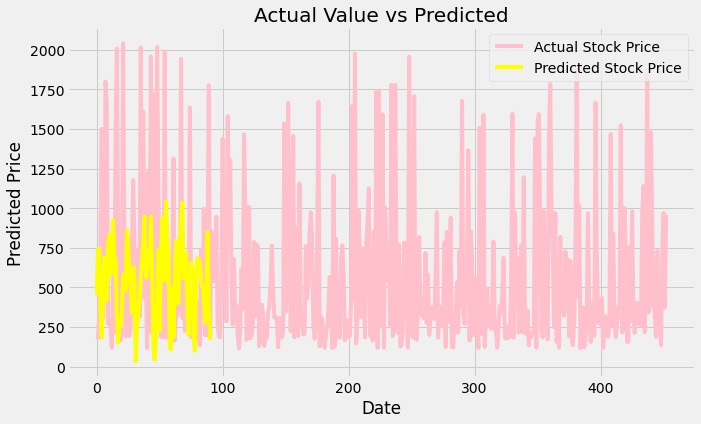

In [319]:
plt.figure(figsize=(10,6))
plt.plot(open_testing_processed, color='pink', label='Actual Stock Price')
plt.plot(predictions , color='yellow', label='Predicted Stock Price')
plt.title('Actual Value vs Predicted')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()



Clearly, the model performs very poorly, so I will try with more features, and train the LSTM Model.

I will use the best 5 features as indicated by XGBoost, and try to predict from there.

In [343]:
dataset = data_df[['Open', 'Close','High','Adj Close','Low']]

In [344]:
dataset.head(5)

,Open,Close,High,Adj Close,Low
0,136.250000,133.899994,136.610001,133.899994,133.139999
1,133.429993,134.690002,135.479996,134.690002,131.809998
2,134.600006,132.250000,134.729996,132.250000,131.649994
3,132.009995,130.000000,132.320007,130.000000,128.800003
4,130.559998,133.520004,133.679993,133.520004,129.029999


In [345]:
#Creating 1D Data into a time-series dataset
def time_series_dataset(dataset, step_size):
	data_X, data_Y = [], []
	for i in range(len(dataset)-step_size-1):
		a = dataset[i:(i+step_size), 0]
		data_X.append(a)
		data_Y.append(dataset[i + step_size, 0])
	return np.array(data_X), np.array(data_Y)

In [346]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

In [347]:
dataset = dataset.reindex(index = dataset.index[::-1])

In [348]:
obs = np.arange(1, len(dataset) + 1, 1)

In [349]:
#Taking different indicators for prediction
OHLC_avg = dataset.mean(axis = 1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]

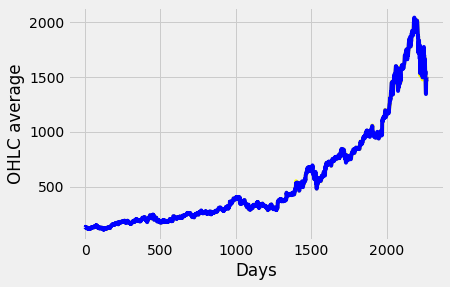

In [350]:
#Plotting all the indicators
plt.plot(OHLC_avg, 'yellow', label = 'OHLC avg')
plt.plot(close_val, 'blue', label = 'Closing price')
plt.xlabel('Days')
plt.ylabel('OHLC average')
plt.show()

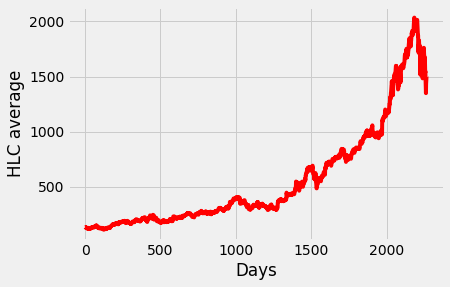

In [351]:
plt.plot(HLC_avg, 'red', label = 'HLC avg')
plt.xlabel('Days')
plt.ylabel('HLC average')
plt.show()

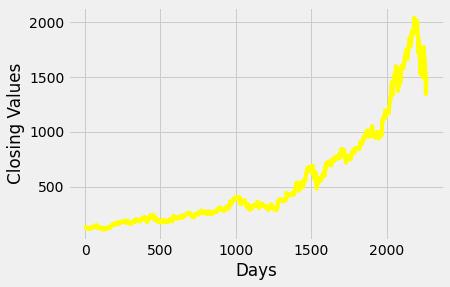

In [352]:
plt.plot(close_val, 'yellow', label = 'Closing price')
plt.xlabel('Days')
plt.ylabel('Closing Values')
plt.show()

In [353]:
#Preparing the time-series dataset
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1)) 
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)

In [354]:
#Dividing into training and testing sets
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

In [355]:
#Time Series dataset(For time T, Values for T+1)
trainX, trainY = time_series_dataset(train_OHLC, 1)
testX, testY = time_series_dataset(test_OHLC, 1)

In [356]:
#Reshaping the training and testing data
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1

### Model(5 features)

In [357]:
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

In [358]:
model.compile(loss='mean_squared_error', optimizer='adagrad',metrics = ['mae']) 
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
1696/1696 - 7s - loss: 0.1049 - mae: 0.2200
Epoch 2/50
1696/1696 - 8s - loss: 0.0782 - mae: 0.1880
Epoch 3/50
1696/1696 - 7s - loss: 0.0670 - mae: 0.1835
Epoch 4/50
1696/1696 - 7s - loss: 0.0608 - mae: 0.1808
Epoch 5/50
1696/1696 - 7s - loss: 0.0570 - mae: 0.1799
Epoch 6/50
1696/1696 - 7s - loss: 0.0545 - mae: 0.1796
Epoch 7/50
1696/1696 - 7s - loss: 0.0527 - mae: 0.1793
Epoch 8/50
1696/1696 - 7s - loss: 0.0513 - mae: 0.1790
Epoch 9/50
1696/1696 - 7s - loss: 0.0501 - mae: 0.1785
Epoch 10/50
1696/1696 - 7s - loss: 0.0491 - mae: 0.1777
Epoch 11/50
1696/1696 - 7s - loss: 0.0481 - mae: 0.1770
Epoch 12/50
1696/1696 - 7s - loss: 0.0472 - mae: 0.1760
Epoch 13/50
1696/1696 - 7s - loss: 0.0463 - mae: 0.1748
Epoch 14/50
1696/1696 - 7s - loss: 0.0455 - mae: 0.1737
Epoch 15/50
1696/1696 - 7s - loss: 0.0446 - mae: 0.1724
Epoch 16/50
1696/1696 - 7s - loss: 0.0438 - mae: 0.1711
Epoch 17/50
1696/1696 - 7s - loss: 0.0429 - mae: 0.1696
Epoch 18/50
1696/1696 - 7s - loss: 0.0421 - mae: 0.1681
E

In [359]:
mae = model.evaluate(testX, testY, batch_size=16)
print('Mean Absolute Error for Y:', mae)

36/36 [==============================] - 0s 3ms/step - loss: 0.0208 - mae: 0.1438
Mean Absolute Error for Y: [0.020764539018273354, 0.14383909106254578]


The mean absolute error is lower than the past model with one feature.

 The error is almost 0.0015. So the training model should be pretty close to testing model.


####Predictions

In [360]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [361]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [362]:
# TRAINING rmse
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train : %.2f' % (trainScore))

Train : 229.06


In [363]:
# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

Test RMSE: 277.28


In [364]:
# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

In [365]:
# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

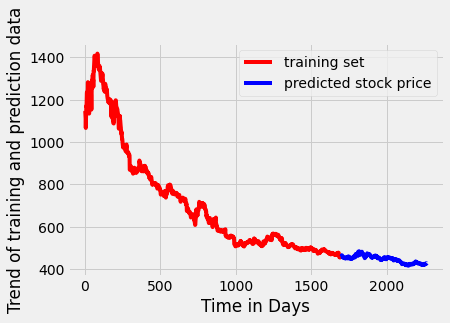

In [368]:
# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('Trend of training and prediction data')
plt.show()

The data was trained for the first 1700 or so days and then tested for the rest. 

The prediction plot has kept up with the pattern, but not to the best potential.

# Conclusion

The predicted values were found to be relying on OHLC(Open-High-Low-Close) values. 

As the days increase the value is decreasing or rather stabilizing. However this is not an accurate way of going about it since Amazon stock prices are still booming not decreasing.

To make further improvements, I will be focusing on not overfitting the model, performing hyperparameter tuning and then trying to predict the stock price movement instead of the price per se.
